In [1]:
#Imports 
import numpy as np
import pandas as pd

import json
import datetime
from datetime import datetime
from shapely.geometry import Polygon, mapping
import geopandas as gpd

import matplotlib.pyplot as plt, mpld3
%matplotlib inline
import folium
from folium.plugins import TimeSliderChoropleth
import branca.colormap as cm



## Get Data 

Links to data: <br>
https://alicia.data.socrata.com/Government/States-21basic/jhnu-yfrj/data <br>
https://www.kaggle.com/sogun3/uspollution/version/1<br>
https://en.wikipedia.org/wiki/Air_quality_index

In [2]:
#Get US states shapefile
states = gpd.read_file('data/states_21basic/geo_export_6fdb6415-82d2-400e-966c-a1d5a3d2ec8b.shp')
states = states[['state_name','geometry']]
print(len(states))
states.head()

51


state_name                                           geometry
0        Hawaii  (POLYGON ((-160.0738033454681 22.0041773479577...
1    Washington  (POLYGON ((-122.4020153103836 48.2252163723779...
2       Montana  POLYGON ((-111.4754253002074 44.70216236909688...
3         Maine  (POLYGON ((-69.77727626137293 44.0741483685119...
4  North Dakota  POLYGON ((-98.73043728833767 45.93827137024809...

In [3]:
#Get polution data
polution = pd.read_csv("data/pollution_us_2000_2016.csv",index_col=0 )
print(len(polution))
print(polution.columns)
polution.head()

/Users/conorosully/miniconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


1746661
Index(['State Code', 'County Code', 'Site Num', 'Address', 'State', 'County',
       'City', 'Date Local', 'NO2 Units', 'NO2 Mean', 'NO2 1st Max Value',
       'NO2 1st Max Hour', 'NO2 AQI', 'O3 Units', 'O3 Mean',
       'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'SO2 Units',
       'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI',
       'CO Units', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI'],
      dtype='object')


State Code  County Code  Site Num                                  Address  \
0           4           13      3002  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN   
1           4           13      3002  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN   
2           4           13      3002  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN   
3           4           13      3002  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN   
4           4           13      3002  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN   

     State    County     City  Date Local          NO2 Units   NO2 Mean  ...  \
0  Arizona  Maricopa  Phoenix  2000-01-01  Parts per billion  19.041667  ...   
1  Arizona  Maricopa  Phoenix  2000-01-01  Parts per billion  19.041667  ...   
2  Arizona  Maricopa  Phoenix  2000-01-01  Parts per billion  19.041667  ...   
3  Arizona  Maricopa  Phoenix  2000-01-01  Parts per billion  19.041667  ...   
4  Arizona  Maricopa  Phoenix  2000-01-02  Parts per billion  22.958333  ...   

           SO2 Units  SO2 Mean  SO2 1st Max Value SO2 1st Max Hour  SO2 AQI  \
0  Parts per billion  3.000000                9.0               21     13.0   
1  Parts per billion  3.000000                9.0               21     13.0   
2  Parts per billion  2.975000                6.6               23      NaN   
3  Parts per billion  2.975000                6.6               23      NaN   
4  Parts per billion  1.958333                3.0               22      4.0   

            CO Units   CO Mean  CO 1st Max Value CO 1st Max Hour  CO AQI  
0  Parts per million  1.145833               4.2              21     NaN  
1  Parts per million  0.878947               2.2              23    25.0  
2  Parts per million  1.145833               4.2              21     NaN  
3  Parts per million  0.878947               2.2              23    25.0  
4  Parts per million  0.850000               1.6              23     NaN  

[5 rows x 28 columns]

# Transform Data

In [4]:
AQI = polution[['State','Date Local', 'NO2 AQI', 'O3 AQI','SO2 AQI','CO AQI']]
#AQI.dropna(inplace = True)

AQI['Max AQI'] = [np.nanmax(x) for x in AQI[['NO2 AQI', 'O3 AQI','SO2 AQI','CO AQI']].values.tolist()]


#Make sure state names are the same
for s in list(AQI['State'].unique()):
    if s not in list(states['state_name']):
        print(s)

AQI = AQI[AQI['State'] != 'Country Of Mexico']
AQI['State'] = ['District of Columbia' if x == 'District Of Columbia' else x for x in AQI['State']]


#Get year and month
AQI['Year'] = [x.split('-')[0] for x in AQI['Date Local']]
AQI['Month'] = [x.split('-')[1] for x in AQI['Date Local']]
AQI.drop(columns=['Date Local'],inplace=True)

#Get max for State for each Year and Month
AQI = AQI.groupby(['State','Year','Month'],as_index=False).max()
AQI.sort_values(['Year',"Month"],inplace=True)

#Get Epoch Values for time 
AQI['Time'] = [datetime(int(Y),int(M),1,0,0).strftime('%s') for Y, M in zip(AQI['Year'],AQI['Month'])]
AQI['Time'] = ['0{}'.format(x) if len(x)==9 else x for x in AQI['Time'] ]

AQI.head()

/Users/conorosully/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


District Of Columbia
Country Of Mexico


State  Year Month  NO2 AQI  O3 AQI  SO2 AQI  CO AQI  \
47                 Arizona  2000    01      132      77     41.0    59.0   
353             California  2000    01      117      67     79.0   126.0   
549               Colorado  2000    01       77      32     71.0    33.0   
899   District of Columbia  2000    01       55      26     76.0    47.0   
1093               Florida  2000    01       60      41     34.0    23.0   

      Max AQI        Time  
47      132.0  0946684800  
353     126.0  0946684800  
549      77.0  0946684800  
899      76.0  0946684800  
1093     60.0  0946684800

In [15]:
AQI_plot = AQI.groupby(['State','Year'],as_index=False).mean()
AQI_plot.columns = ['State', 'Year', 'NO2', 'O3', 'SO2', 'CO','Max AQI']
AQI_plot.head()

State  Year        NO2         O3        SO2         CO    Max AQI
0  Alabama  2013  43.000000  30.000000  50.000000   9.000000  50.000000
1  Alabama  2014  39.000000  56.333333  39.166667   8.333333  62.666667
2  Alabama  2015  35.000000  67.636364  41.090909   7.363636  69.636364
3  Alabama  2016  39.200000  70.600000  38.000000  10.400000  70.600000
4   Alaska  2014  40.666667  26.333333  29.666667  11.833333  46.166667

In [16]:
# Get state ids 
ID = {}
for i,s in enumerate(states['state_name']):
    ID[s] = i

### Create Style Dictionary

In [22]:
import pprint
pp = pprint.PrettyPrinter()

styledict = newStyle()
pp.pprint(styledict)



{0: {'0946684800': {'color': 'ffffff', 'opacity': 0.5},
     '0949363200': {'color': 'ffffff', 'opacity': 0.5},
     '0951868800': {'color': 'ffffff', 'opacity': 0.5},
     '0954543600': {'color': 'ffffff', 'opacity': 0.5},
     '0957135600': {'color': 'ffffff', 'opacity': 0.5},
     '0959814000': {'color': 'ffffff', 'opacity': 0.5},
     '0962406000': {'color': 'ffffff', 'opacity': 0.5},
     '0965084400': {'color': 'ffffff', 'opacity': 0.5},
     '0967762800': {'color': 'ffffff', 'opacity': 0.5},
     '0970354800': {'color': 'ffffff', 'opacity': 0.5},
     '0973036800': {'color': 'ffffff', 'opacity': 0.5},
     '0975628800': {'color': 'ffffff', 'opacity': 0.5},
     '0978307200': {'color': 'ffffff', 'opacity': 0.5},
     '0980985600': {'color': 'ffffff', 'opacity': 0.5},
     '0983404800': {'color': 'ffffff', 'opacity': 0.5},
     '0986079600': {'color': 'ffffff', 'opacity': 0.5},
     '0988671600': {'color': 'ffffff', 'opacity': 0.5},
     '0991350000': {'color': 'ffffff', 'opacity'

     '1088636400': {'color': 'ffffff', 'opacity': 0.5},
     '1091314800': {'color': 'ffffff', 'opacity': 0.5},
     '1093993200': {'color': 'ffffff', 'opacity': 0.5},
     '1096585200': {'color': 'ffffff', 'opacity': 0.5},
     '1099267200': {'color': 'ffffff', 'opacity': 0.5},
     '1101859200': {'color': 'ffffff', 'opacity': 0.5},
     '1104537600': {'color': 'ffffff', 'opacity': 0.5},
     '1107216000': {'color': 'ffffff', 'opacity': 0.5},
     '1109635200': {'color': 'ffffff', 'opacity': 0.5},
     '1112310000': {'color': 'ffffff', 'opacity': 0.5},
     '1114902000': {'color': 'ffffff', 'opacity': 0.5},
     '1117580400': {'color': 'ffffff', 'opacity': 0.5},
     '1120172400': {'color': 'ffffff', 'opacity': 0.5},
     '1122850800': {'color': 'ffffff', 'opacity': 0.5},
     '1125529200': {'color': 'ffffff', 'opacity': 0.5},
     '1128121200': {'color': 'ffffff', 'opacity': 0.5},
     '1130803200': {'color': 'ffffff', 'opacity': 0.5},
     '1133395200': {'color': 'ffffff', 'opacity'

     '0978307200': {'color': 'ffffff', 'opacity': 0.5},
     '0980985600': {'color': 'ffffff', 'opacity': 0.5},
     '0983404800': {'color': 'ffffff', 'opacity': 0.5},
     '0986079600': {'color': 'ffffff', 'opacity': 0.5},
     '0988671600': {'color': 'ffffff', 'opacity': 0.5},
     '0991350000': {'color': 'ffffff', 'opacity': 0.5},
     '0993942000': {'color': 'ffffff', 'opacity': 0.5},
     '0996620400': {'color': 'ffffff', 'opacity': 0.5},
     '0999298800': {'color': 'ffffff', 'opacity': 0.5},
     '1001890800': {'color': 'ffffff', 'opacity': 0.5},
     '1004572800': {'color': 'ffffff', 'opacity': 0.5},
     '1007164800': {'color': 'ffffff', 'opacity': 0.5},
     '1009843200': {'color': 'ffffff', 'opacity': 0.5},
     '1012521600': {'color': 'ffffff', 'opacity': 0.5},
     '1014940800': {'color': 'ffffff', 'opacity': 0.5},
     '1017615600': {'color': 'ffffff', 'opacity': 0.5},
     '1020207600': {'color': 'ffffff', 'opacity': 0.5},
     '1022886000': {'color': 'ffffff', 'opacity'

      '1001890800': {'color': 'ffffff', 'opacity': 0.5},
      '1004572800': {'color': 'ffffff', 'opacity': 0.5},
      '1007164800': {'color': 'ffffff', 'opacity': 0.5},
      '1009843200': {'color': 'ffffff', 'opacity': 0.5},
      '1012521600': {'color': 'ffffff', 'opacity': 0.5},
      '1014940800': {'color': 'ffffff', 'opacity': 0.5},
      '1017615600': {'color': 'ffffff', 'opacity': 0.5},
      '1020207600': {'color': 'ffffff', 'opacity': 0.5},
      '1022886000': {'color': 'ffffff', 'opacity': 0.5},
      '1025478000': {'color': 'ffffff', 'opacity': 0.5},
      '1028156400': {'color': 'ffffff', 'opacity': 0.5},
      '1030834800': {'color': 'ffffff', 'opacity': 0.5},
      '1033426800': {'color': 'ffffff', 'opacity': 0.5},
      '1036108800': {'color': 'ffffff', 'opacity': 0.5},
      '1038700800': {'color': 'ffffff', 'opacity': 0.5},
      '1041379200': {'color': 'ffffff', 'opacity': 0.5},
      '1044057600': {'color': 'ffffff', 'opacity': 0.5},
      '1046476800': {'color': '

 19: {'0946684800': {'color': 'ffffff', 'opacity': 0.5},
      '0949363200': {'color': 'ffffff', 'opacity': 0.5},
      '0951868800': {'color': 'ffffff', 'opacity': 0.5},
      '0954543600': {'color': 'ffffff', 'opacity': 0.5},
      '0957135600': {'color': 'ffffff', 'opacity': 0.5},
      '0959814000': {'color': 'ffffff', 'opacity': 0.5},
      '0962406000': {'color': 'ffffff', 'opacity': 0.5},
      '0965084400': {'color': 'ffffff', 'opacity': 0.5},
      '0967762800': {'color': 'ffffff', 'opacity': 0.5},
      '0970354800': {'color': 'ffffff', 'opacity': 0.5},
      '0973036800': {'color': 'ffffff', 'opacity': 0.5},
      '0975628800': {'color': 'ffffff', 'opacity': 0.5},
      '0978307200': {'color': 'ffffff', 'opacity': 0.5},
      '0980985600': {'color': 'ffffff', 'opacity': 0.5},
      '0983404800': {'color': 'ffffff', 'opacity': 0.5},
      '0986079600': {'color': 'ffffff', 'opacity': 0.5},
      '0988671600': {'color': 'ffffff', 'opacity': 0.5},
      '0991350000': {'color': '

      '1438383600': {'color': '#FFFF00', 'opacity': 1},
      '1441062000': {'color': '#FFFF00', 'opacity': 1},
      '1443654000': {'color': '#FFFF00', 'opacity': 1},
      '1446336000': {'color': '#008000', 'opacity': 1},
      '1448928000': {'color': '#008000', 'opacity': 1},
      '1451606400': {'color': '#008000', 'opacity': 1},
      '1454284800': {'color': '#FFFF00', 'opacity': 1},
      '1456790400': {'color': '#008000', 'opacity': 1},
      '1459465200': {'color': '#FFA500', 'opacity': 1},
      '1462057200': {'color': 'ffffff', 'opacity': 0.5}},
 23: {'0946684800': {'color': 'ffffff', 'opacity': 0.5},
      '0949363200': {'color': 'ffffff', 'opacity': 0.5},
      '0951868800': {'color': 'ffffff', 'opacity': 0.5},
      '0954543600': {'color': 'ffffff', 'opacity': 0.5},
      '0957135600': {'color': 'ffffff', 'opacity': 0.5},
      '0959814000': {'color': 'ffffff', 'opacity': 0.5},
      '0962406000': {'color': 'ffffff', 'opacity': 0.5},
      '0965084400': {'color': 'ffffff',

      '1328054400': {'color': '#008000', 'opacity': 1},
      '1330560000': {'color': '#008000', 'opacity': 1},
      '1333234800': {'color': '#FFFF00', 'opacity': 1},
      '1335826800': {'color': '#FFFF00', 'opacity': 1},
      '1338505200': {'color': '#FF0000', 'opacity': 1},
      '1341097200': {'color': '#FFA500', 'opacity': 1},
      '1343775600': {'color': '#FFA500', 'opacity': 1},
      '1346454000': {'color': '#FFFF00', 'opacity': 1},
      '1349046000': {'color': '#008000', 'opacity': 1},
      '1351728000': {'color': '#008000', 'opacity': 1},
      '1354320000': {'color': '#008000', 'opacity': 1},
      '1356998400': {'color': '#008000', 'opacity': 1},
      '1359676800': {'color': '#008000', 'opacity': 1},
      '1362096000': {'color': '#008000', 'opacity': 1},
      '1364770800': {'color': '#FFFF00', 'opacity': 1},
      '1367362800': {'color': '#FFFF00', 'opacity': 1},
      '1370041200': {'color': '#FFFF00', 'opacity': 1},
      '1372633200': {'color': '#FFA500', 'opacit

      '0999298800': {'color': 'ffffff', 'opacity': 0.5},
      '1001890800': {'color': 'ffffff', 'opacity': 0.5},
      '1004572800': {'color': 'ffffff', 'opacity': 0.5},
      '1007164800': {'color': 'ffffff', 'opacity': 0.5},
      '1009843200': {'color': 'ffffff', 'opacity': 0.5},
      '1012521600': {'color': 'ffffff', 'opacity': 0.5},
      '1014940800': {'color': 'ffffff', 'opacity': 0.5},
      '1017615600': {'color': 'ffffff', 'opacity': 0.5},
      '1020207600': {'color': 'ffffff', 'opacity': 0.5},
      '1022886000': {'color': 'ffffff', 'opacity': 0.5},
      '1025478000': {'color': 'ffffff', 'opacity': 0.5},
      '1028156400': {'color': 'ffffff', 'opacity': 0.5},
      '1030834800': {'color': 'ffffff', 'opacity': 0.5},
      '1033426800': {'color': 'ffffff', 'opacity': 0.5},
      '1036108800': {'color': 'ffffff', 'opacity': 0.5},
      '1038700800': {'color': 'ffffff', 'opacity': 0.5},
      '1041379200': {'color': 'ffffff', 'opacity': 0.5},
      '1044057600': {'color': '

      '1241132400': {'color': 'ffffff', 'opacity': 0.5},
      '1243810800': {'color': 'ffffff', 'opacity': 0.5},
      '1246402800': {'color': 'ffffff', 'opacity': 0.5},
      '1249081200': {'color': 'ffffff', 'opacity': 0.5},
      '1251759600': {'color': 'ffffff', 'opacity': 0.5},
      '1254351600': {'color': 'ffffff', 'opacity': 0.5},
      '1257033600': {'color': 'ffffff', 'opacity': 0.5},
      '1259625600': {'color': 'ffffff', 'opacity': 0.5},
      '1262304000': {'color': 'ffffff', 'opacity': 0.5},
      '1264982400': {'color': 'ffffff', 'opacity': 0.5},
      '1267401600': {'color': 'ffffff', 'opacity': 0.5},
      '1270076400': {'color': 'ffffff', 'opacity': 0.5},
      '1272668400': {'color': 'ffffff', 'opacity': 0.5},
      '1275346800': {'color': 'ffffff', 'opacity': 0.5},
      '1277938800': {'color': 'ffffff', 'opacity': 0.5},
      '1280617200': {'color': 'ffffff', 'opacity': 0.5},
      '1283295600': {'color': 'ffffff', 'opacity': 0.5},
      '1285887600': {'color': '

      '1267401600': {'color': '#FFFF00', 'opacity': 1},
      '1270076400': {'color': '#FFFF00', 'opacity': 1},
      '1272668400': {'color': '#FFA500', 'opacity': 1},
      '1275346800': {'color': '#FFFF00', 'opacity': 1},
      '1277938800': {'color': '#FFA500', 'opacity': 1},
      '1280617200': {'color': '#FFA500', 'opacity': 1},
      '1283295600': {'color': '#FFFF00', 'opacity': 1},
      '1285887600': {'color': '#FFA500', 'opacity': 1},
      '1288569600': {'color': '#FFFF00', 'opacity': 1},
      '1291161600': {'color': '#FFFF00', 'opacity': 1},
      '1293840000': {'color': '#FFFF00', 'opacity': 1},
      '1296518400': {'color': '#FFFF00', 'opacity': 1},
      '1298937600': {'color': '#FFFF00', 'opacity': 1},
      '1301612400': {'color': '#FFFF00', 'opacity': 1},
      '1304204400': {'color': '#FFA500', 'opacity': 1},
      '1306882800': {'color': '#FFA500', 'opacity': 1},
      '1309474800': {'color': '#FFA500', 'opacity': 1},
      '1312153200': {'color': '#FFA500', 'opacit

      '1396306800': {'color': '#FFFF00', 'opacity': 1},
      '1398898800': {'color': '#FFFF00', 'opacity': 1},
      '1401577200': {'color': '#FFA500', 'opacity': 1},
      '1404169200': {'color': '#FFFF00', 'opacity': 1},
      '1406847600': {'color': '#FFA500', 'opacity': 1},
      '1409526000': {'color': '#008000', 'opacity': 1},
      '1412118000': {'color': '#008000', 'opacity': 1},
      '1414800000': {'color': '#FFFF00', 'opacity': 1},
      '1417392000': {'color': '#008000', 'opacity': 1},
      '1420070400': {'color': '#FFFF00', 'opacity': 1},
      '1422748800': {'color': '#008000', 'opacity': 1},
      '1425168000': {'color': '#FFFF00', 'opacity': 1},
      '1427842800': {'color': '#FFFF00', 'opacity': 1},
      '1430434800': {'color': '#FFA500', 'opacity': 1},
      '1433113200': {'color': '#FFFF00', 'opacity': 1},
      '1435705200': {'color': '#FFFF00', 'opacity': 1},
      '1438383600': {'color': '#FFA500', 'opacity': 1},
      '1441062000': {'color': '#FFFF00', 'opacit

      '1180652400': {'color': 'ffffff', 'opacity': 0.5},
      '1183244400': {'color': 'ffffff', 'opacity': 0.5},
      '1185922800': {'color': 'ffffff', 'opacity': 0.5},
      '1188601200': {'color': 'ffffff', 'opacity': 0.5},
      '1191193200': {'color': 'ffffff', 'opacity': 0.5},
      '1193875200': {'color': 'ffffff', 'opacity': 0.5},
      '1196467200': {'color': 'ffffff', 'opacity': 0.5},
      '1199145600': {'color': 'ffffff', 'opacity': 0.5},
      '1201824000': {'color': 'ffffff', 'opacity': 0.5},
      '1204329600': {'color': 'ffffff', 'opacity': 0.5},
      '1207004400': {'color': 'ffffff', 'opacity': 0.5},
      '1209596400': {'color': 'ffffff', 'opacity': 0.5},
      '1212274800': {'color': 'ffffff', 'opacity': 0.5},
      '1214866800': {'color': 'ffffff', 'opacity': 0.5},
      '1217545200': {'color': 'ffffff', 'opacity': 0.5},
      '1220223600': {'color': 'ffffff', 'opacity': 0.5},
      '1222815600': {'color': 'ffffff', 'opacity': 0.5},
      '1225497600': {'color': '

In [17]:
#Create initial style variable - to define structure of the style disctionary
initial_style = {}
default = {'color': 'ffffff', 'opacity': 0.5}

unique_states = list(states['state_name'].unique())
unique_times = list(AQI['Time'].unique())

for s in unique_states:
    state_default = {}
    for t in unique_times:
        state_default[t] =  {'color': 'ffffff', 'opacity': 0.5}
    
    initial_style[ID[s]] = state_default



#Used to create new style dictionary based on AQI data
def newStyle():
    new_style = initial_style

    unique_states = list(AQI['State'].unique())
    
    for s in unique_states:
        state_ID = ID[s]
        state_AQI = AQI[AQI['State'] == s]

        for t,max_aqi in zip(state_AQI['Time'],state_AQI['Max AQI']):
            style = {}
            style['color'] = getColor(max_aqi)
            style['opacity'] = 1
            new_style[state_ID][t] = style
    return new_style

# Used to dedine choropleth button style
def style_function(feature):
    return {
        'fillOpacity': 0,
        'weight': 1,
        'fillColor': '#000000',
        'color': '#000000'
    }

#Used to determine what color choropleth tiles take on
def getColor(aqi):
    if  aqi <= 50:
        return '#008000'
    elif aqi <= 100:
        return '#FFFF00'
    elif aqi <= 150:
        return '#FFA500'
    elif aqi <= 200:
        return '#FF0000'
    elif aqi <= 300:
        return '#800080'
    elif aqi <= 500:
        return '#800000'  

#Used to create maps for each state
def getFigure(state):
    
    AQI_state = AQI_plot[AQI_plot['State'] == state]
    
    if len(AQI_state) < 2:
        html = "{} <br>Data currently not available for this state".format(state)
        
    else:
        fig = plt.figure(figsize=(8,4))
        year = [int(x) for x in AQI_state['Year']]

        plt.plot(year,AQI_state['NO2'])
        plt.plot(year,AQI_state['O3'])
        plt.plot(year,AQI_state['SO2'])
        plt.plot(year,AQI_state['CO'])
        
        plt.title(state,size = 18)
        plt.xlabel('Year',size =14)
        plt.ylabel('Mean AQI',size =14)
        #plt.xticks(rotation=90)
        #plt.xticks(AQI_state['Year'])
        plt.legend(loc =1)
        html = mpld3.fig_to_html(fig)
    
    iframe = folium.IFrame(html=html,width = 600, height = 300)

    return iframe

#Define choropleth legend
step = cm.StepColormap(
    ['#008000', '#FFFF00', '#FFA500','#FF0000','#800080','#800000'],
    vmin=0, vmax=500,
    index=[0, 50,100,150,200,300,500],
    caption='Levels of Health Concern (AQI Levels)')

## Plot data 

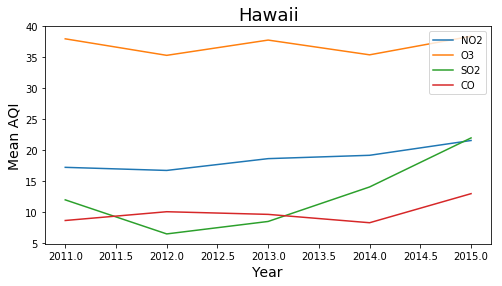

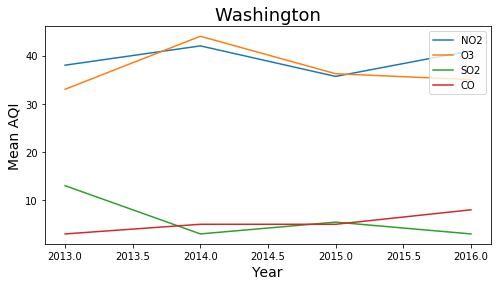

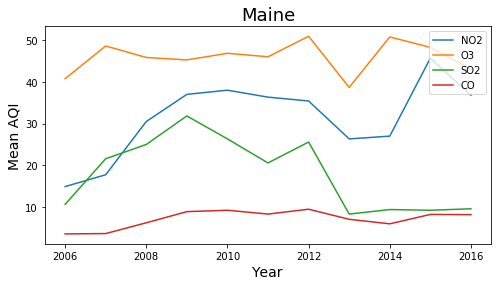

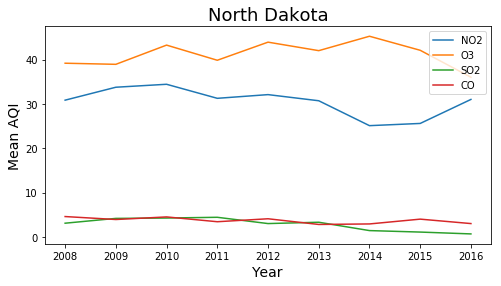

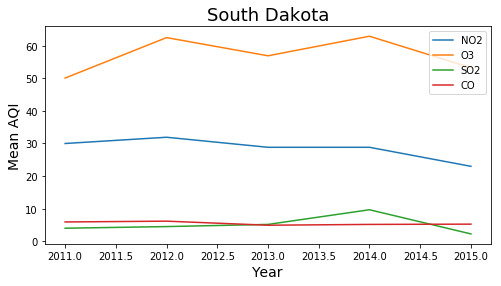

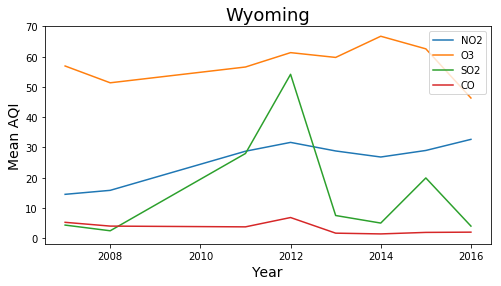

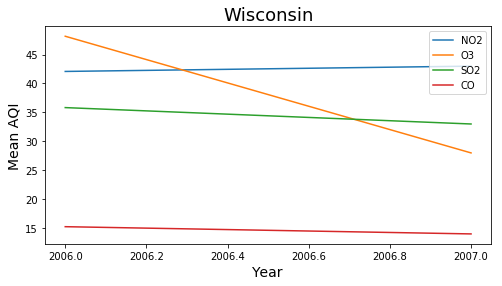

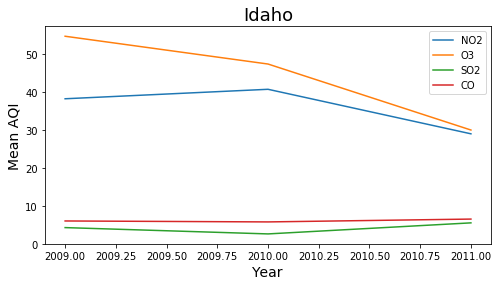

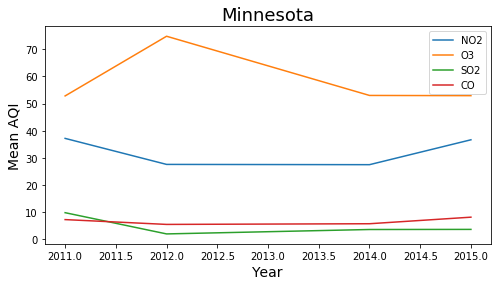

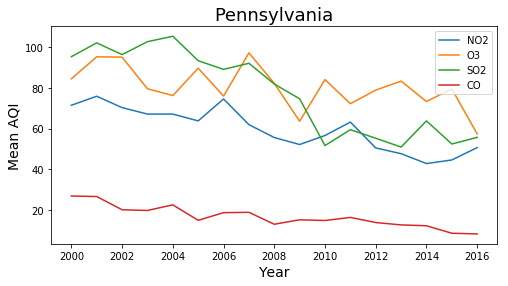

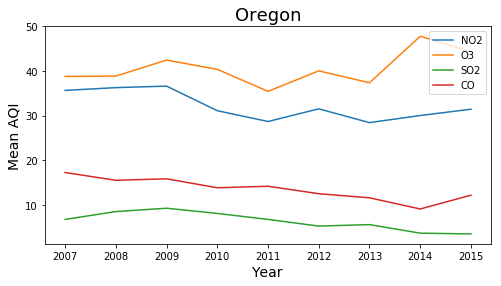

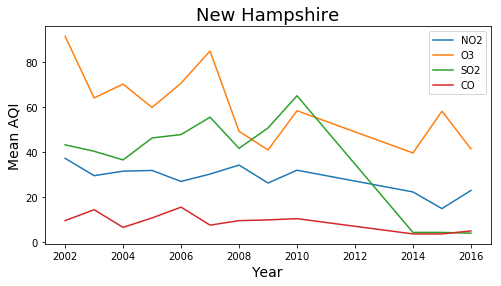

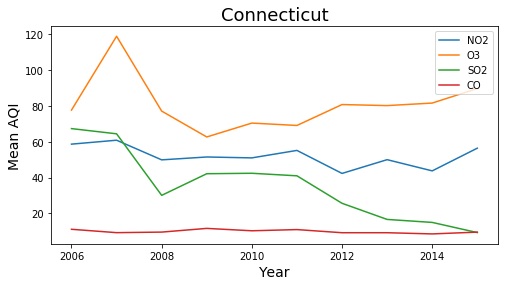

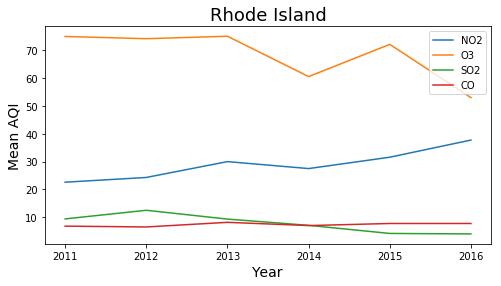

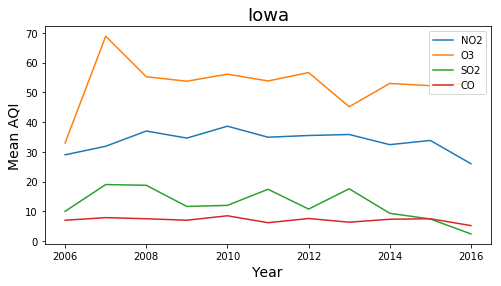

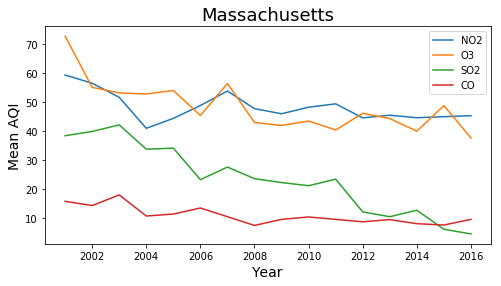

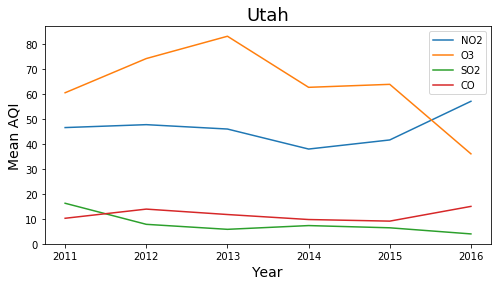

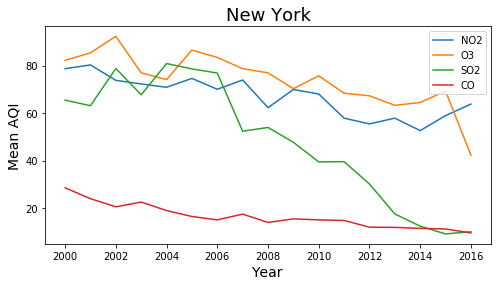

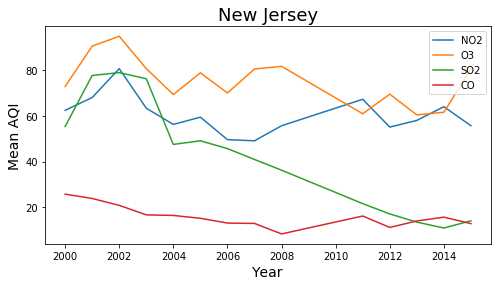

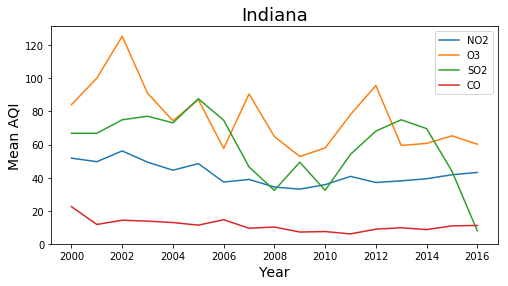

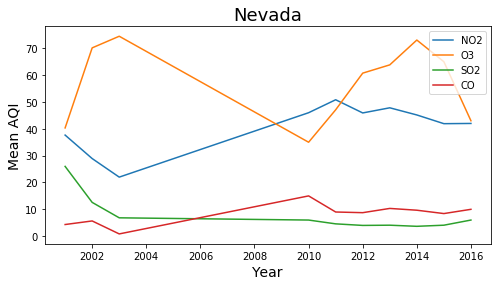

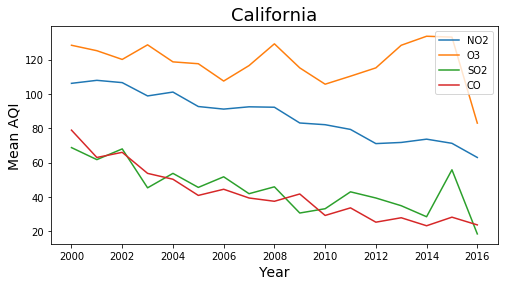

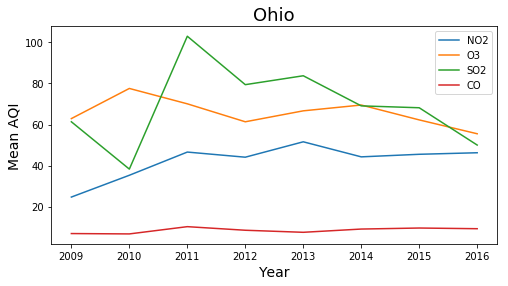

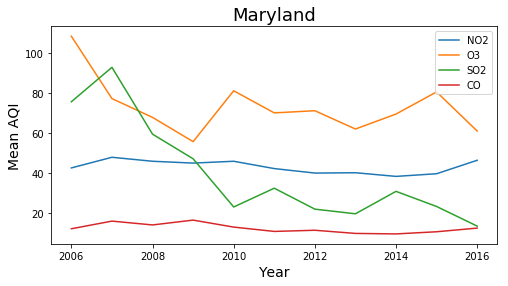

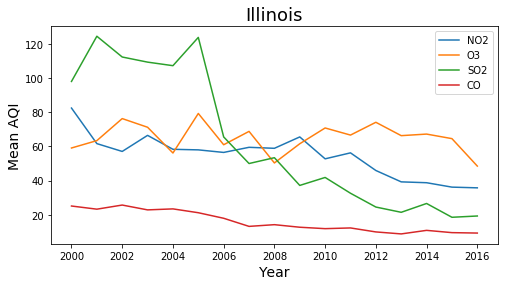

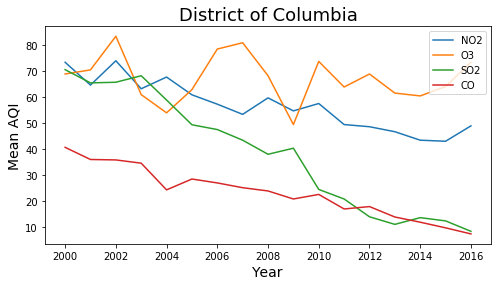

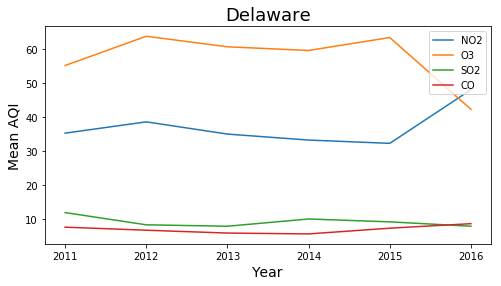

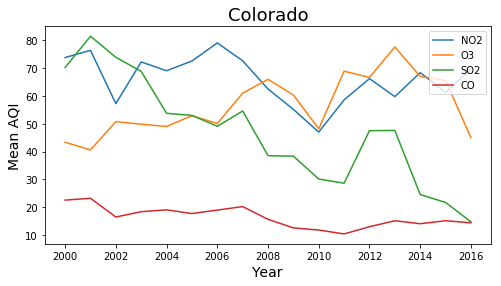

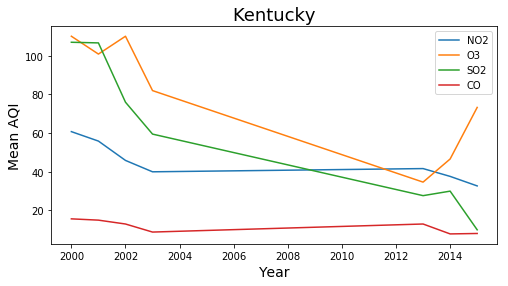

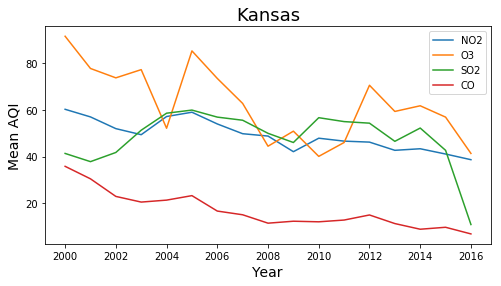

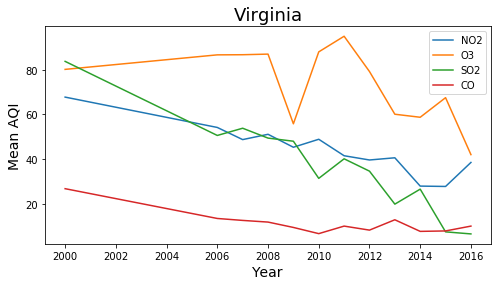

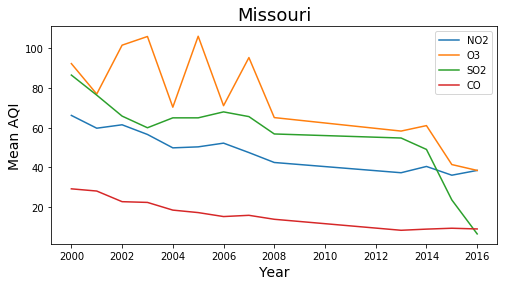

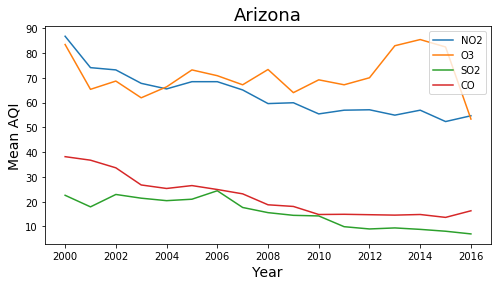

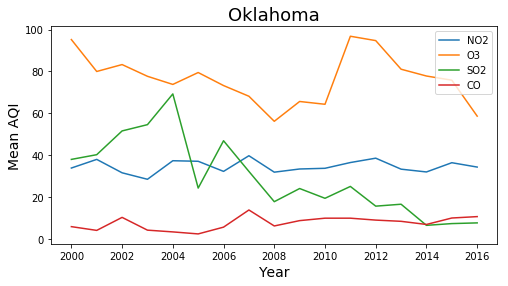

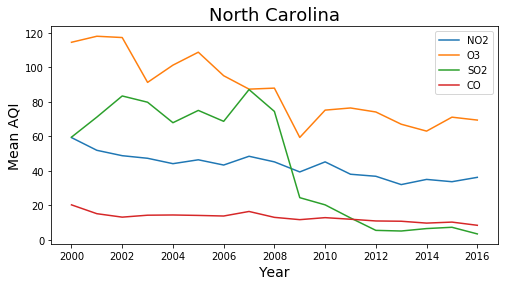

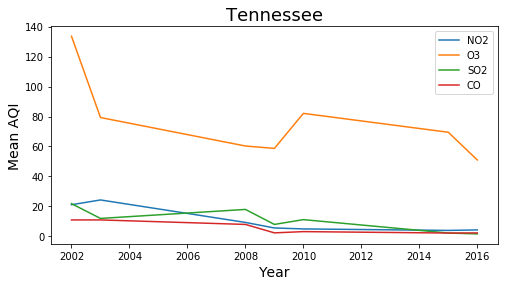

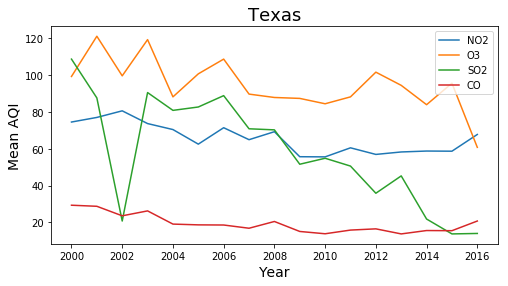

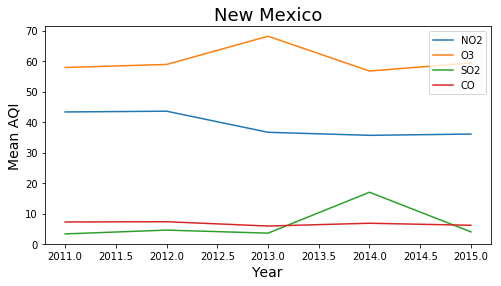

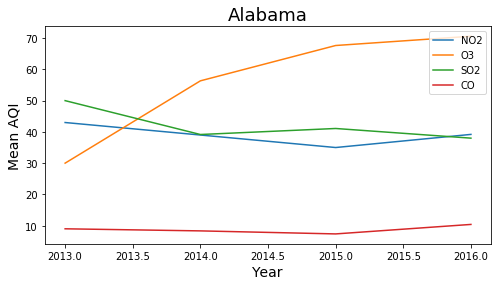

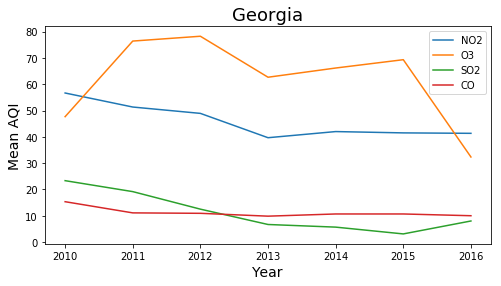

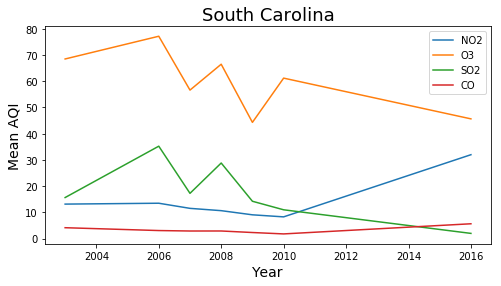

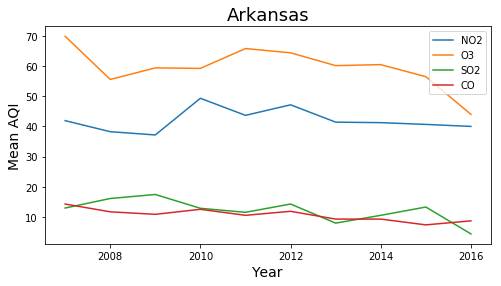

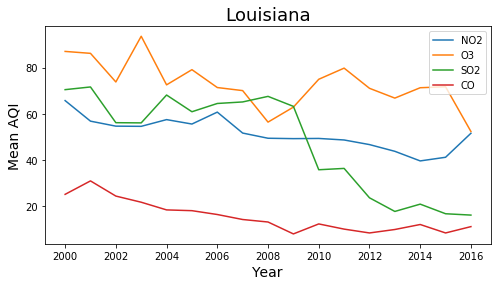

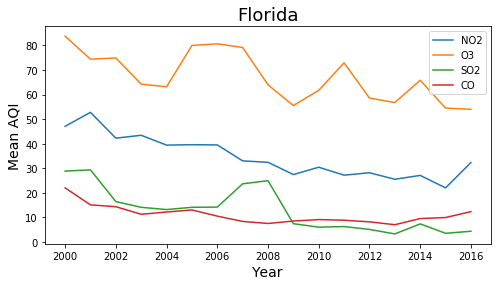

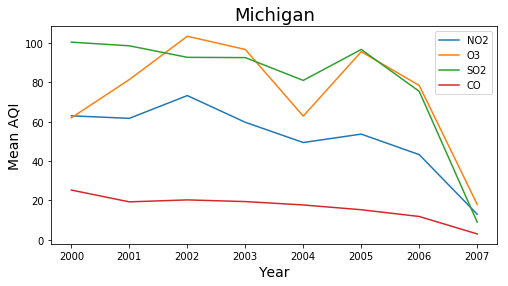

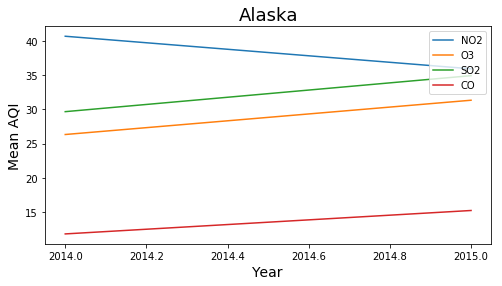

In [18]:
#Create folium map
m = folium.Map(location=[50.77500, -100],zoom_start=3) #Initialize map

styledict = newStyle()
ts = TimeSliderChoropleth(states.to_json(), styledict)

m.add_child(ts)

for i in range(len(states)):
    state_marker = folium.GeoJson(data=mapping(states.loc[i]['geometry']),style_function=style_function )
    state_marker.add_child(folium.Popup(getFigure(states.loc[i]['state_name']),max_width=1000))
    m.add_child(state_marker)
    
    
colormap = step
m.add_child(colormap)
m.save("us_polution.html")
m